# LETID - Outdoor Geospatioal Demo

![PVDeg Logo](../PVD_logo.png)

***
2023.10.13 - M. Springer
***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pvdeg
from pvdeg import DATA_DIR
import dask.array as da
import dask.dataframe as dd
import xarray as xr
import os

# Single location example

In [2]:
weather_file = os.path.join(DATA_DIR,'psm3_demo.csv')

WEATHER, META = pvdeg.weather.read(weather_file,'psm')

In [3]:
kwargs = {'tau_0': 115, # us, carrier lifetime in non-degraded states, e.g. LETID/LID states A or C
        'tau_deg': 55, # us, carrier lifetime in fully-degraded state, e.g. LETID/LID state B
        'wafer_thickness': 180, # um
        's_rear': 46, # cm/s
        'cell_area': 243, # cm^2
        'na_0': 100,
        'nb_0': 0,
        'nc_0': 0,
        'mechanism_params': 'repins'
    }

In [4]:
pvdeg.letid.calc_letid_outdoors(weather_df=WEATHER, meta=META, **kwargs)

,Datetime,Temperature,Injection,NA,NB,NC,tau,Jsc,Voc,Isc,FF,Pmp,Pmp_norm
0,1999-01-01 00:30:00-07:00,0.0,NaN,100.0,0.000000e+00,0.000000e+00,115.0,41.593861,0.666329,10.107308,0.840987,5.663874,1.0
1,1999-01-01 01:30:00-07:00,0.0,NaN,100.0,1.702422e-15,0.000000e+00,115.0,41.593861,0.666329,10.107308,0.840987,5.663874,1.0
2,1999-01-01 02:30:00-07:00,0.0,NaN,100.0,3.404843e-15,5.403329e-36,115.0,41.593861,0.666329,10.107308,0.840987,5.663874,1.0
3,1999-01-01 03:30:00-07:00,0.0,NaN,100.0,5.107265e-15,1.620999e-35,115.0,41.593861,0.666329,10.107308,0.840987,5.663874,1.0
4,1999-01-01 04:30:00-07:00,0.0,NaN,100.0,6.809686e-15,3.241997e-35,115.0,41.593861,0.666329,10.107308,0.840987,5.663874,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1999-12-31 19:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.328504,NaN,NaN
8756,1999-12-31 20:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.328504,NaN,NaN
8757,1999-12-31 21:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.328504,NaN,NaN
8758,1999-12-31 22:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.328504,NaN,NaN


## 1 Start distributed compute cluster - DASK

In [2]:
pvdeg.geospatial.start_dask()

AttributeError: module 'pvdeg' has no attribute 'geospatial'

/projects/pvsoiling/pvdeg/envs/py310/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


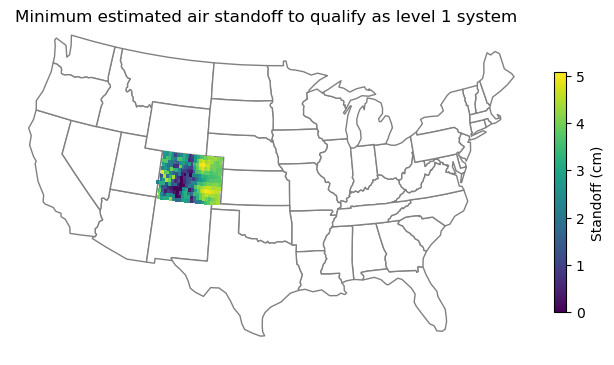

In [3]:
# Get weather data
weather_db = 'NSRDB'

weather_arg = {'satellite': 'Americas',
               'names': 2022,
               'NREL_HPC': True,
               'attributes': ['air_temperature', 'wind_speed', 'dhi', 'ghi', 'dni', 'relative_humidity']}

weather_ds, meta_df = pvdeg.weather.get(weather_db, geospatial=True, **weather_arg)

# Define geographical region
meta_CO = meta_df[meta_df['state'] == 'Colorado']
meta_CO_sub, gids_NM_sub = pvdeg.utilities.gid_downsampling(meta_CO, 4)

weather_CO_sub = weather_ds.sel(gid=meta_CO_sub.index)



In [ ]:
# Define desired analysis
geo = {'func': pvdeg.letid.calc_letid_outdoors,
       'weather_ds': weather_CO_sub,
       'meta_df': meta_CO_sub}

letid_res = pvdeg.geospatial.analysis(**geo)



In [ ]:
# Plot results
fig, ax = pvdeg.geospatial.plot_USA(standoff_res['x'],
                   cmap='viridis', vmin=0, vmax=None,
                   title='Minimum estimated air standoff to qualify as level 1 system',
                   cb_title='Standoff (cm)')